# Dialogue Graph Auto Construction based on data with a regular structure


Goal: Extract regular structures from the data by building a dialogue graph
    
Tasks: 
* Cluster dialog data using embeddings of pre-trained models (BERT, ConveRT, S-BERT…)
* Evaluate the quality of clustering using intent’s labeling of Multi-WoZ dataset 
* Linking clusters of dialogs using naive approaches (Estimation of Probabilities by Frequency Models)
* Try other approaches (Deep Neural Networks) for linking clusters and improve the naive approach


In [1]:
from datasets import load_dataset
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter
from torch import nn
from torch_geometric.data import Data
from torch_scatter import scatter_add
from torch_geometric.nn import MessagePassing
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from dgl.dataloading import GraphDataLoader
from torch.utils.data import DataLoader
from tqdm import tqdm

import pandas as pd
import numpy as np
import networkx as nx
import sys
import os
import torch
import math
import tensorflow as tf
import random
import dgl
import torch.nn.functional as F
import dgl.nn.pytorch as dglnn
import torch.nn as nn

sys.path.insert(1, '/cephfs/home/ledneva/final_work/common_utils/')
from preprocess import Clusters, get_accuracy_k, get_all_accuracy_k, get_all_accuracy_printer

2023-02-23 22:55:13.444462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 22:55:14.658916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-23 22:55:14.659055: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-23 22:55:14.659067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
print(torch.cuda.device_count())

4


In [3]:
import wandb
wandb.init(project="MP-tuning")

wandb: Currently logged in as: ladanik (ladanik13). Use `wandb login --relogin` to force relogin


In [4]:
from data_function_uttr_embs import get_data
from GAT_functions_uttr_embs import get_data_dgl_no_cycles
from early_stopping_tools import LRScheduler, EarlyStopping

In [5]:
first_num_clusters = 400
second_num_clusters = 60

In [6]:
embs_path = "/cephfs/home/ledneva/final_work/convert_one_prev_embeddings.csv"
clusters = Clusters(first_num_clusters, second_num_clusters, embs_path)
clusters.form_clusters()

The data is loading...


No config specified, defaulting to: multi_woz_v22/v2.2_active_only
Found cached dataset multi_woz_v22 (/home/ledneva/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/6719c8b21478299411a0c6fdb7137c3ebab2e6425129af831687fb7851c69eb5)


  0%|          | 0/3 [00:00<?, ?it/s]

The embeddings are loading...
The first stage of clustering has begun...
The second stage of clustering has begun...
The searching clusters for test and validation has begun...
Intent metric conveRT-one-prev, 60 two-stage clusters,                 user: 0.7291723035160729
Intent metric conveRT-one-prev, 60 two-stage clusters,                 system: 0.7407125368469983


In [9]:
# counting unique intents
unique_intent = []

for intents in clusters.user_train_df['intent']:
    unique_intent += intents
for intents in clusters.system_train_df['intent']:
    unique_intent += intents

unique_intent = list(set(unique_intent))  
num_intents = len(unique_intent)
all_intents = []

for i in range(second_num_clusters):
    cluster = clusters.train_user_df[clusters.train_user_df['cluster'] == i]

    intents = []
    for intent_arr in cluster['intent']:
        intents += intent_arr

    intent_count = np.zeros(num_intents)
    for j, intent in enumerate(unique_intent):
        intent_count[j] = intents.count(intent)
    all_intents.append(np.array(intent_count) / sum(intent_count))

for i in range(second_num_clusters):
    cluster = clusters.train_system_df[clusters.train_system_df['cluster'] == i]

    intents = []
    for intent_arr in cluster['intent']:
        intents += intent_arr

    intent_count = np.zeros(num_intents)
    for j, intent in enumerate(unique_intent):
        intent_count[j] = intents.count(intent)
    all_intents.append(np.array(intent_count) / sum(intent_count))

## 4.3 Functions

Functions generating butches for two types of graphs and metric function

In [10]:
device = torch.device('cuda:2')

In [11]:
top_k = 15
batch_size = 256

## 4.4 Preprocessing data

Data generation and preparation

In [12]:
user_train_x, user_train_y, sys_train_x, sys_train_y = get_data(clusters.train_dataset, 
                                                                top_k, second_num_clusters, 
                                                                clusters.train_user_df, 
                                                                clusters.train_system_df,
                                                                np.array(clusters.train_user_embs),
                                                                np.array(clusters.train_system_embs))
user_test_x, user_test_y, sys_test_x, sys_test_y = get_data(clusters.test_dataset, 
                                                            top_k, second_num_clusters,
                                                            clusters.test_user_df,
                                                            clusters.test_system_df,
                                                            np.array(clusters.test_user_embs),
                                                            np.array(clusters.test_system_embs))
user_valid_x, user_valid_y, sys_valid_x, sys_valid_y = get_data(clusters.validation_dataset, 
                                                                top_k, second_num_clusters,
                                                                clusters.valid_user_df, 
                                                                clusters.valid_system_df,
                                                                np.array(clusters.valid_user_embs),
                                                                np.array(clusters.valid_system_embs))

In [13]:
user_train_data = get_data_dgl_no_cycles(user_train_x, user_train_y, 1, top_k, batch_size)

In [14]:
sys_train_data = get_data_dgl_no_cycles(sys_train_x, sys_train_y, 1, top_k, batch_size)

In [15]:
user_test_data = get_data_dgl_no_cycles(user_test_x, user_test_y, 0, top_k, batch_size)

In [16]:
sys_test_data = get_data_dgl_no_cycles(sys_test_x, sys_test_y, 0, top_k, batch_size)

In [17]:
user_valid_data = get_data_dgl_no_cycles(user_valid_x, user_valid_y, 1, top_k, batch_size)

In [18]:
sys_valid_data = get_data_dgl_no_cycles(sys_valid_x, sys_valid_y, 1, top_k, batch_size)

In [19]:
# обучаемые веса для суммирования
linear_weights = np.zeros(top_k)
linear_weights[...] = 1 / top_k
linear_weights = torch.tensor(linear_weights).view(1, -1)
linear_weights = linear_weights.to(device)

In [20]:
intent_embs_dim = len(all_intents[0])
centre_embs_dim = len(clusters.user_cluster_embs[0])

In [21]:
num_comps = 512

In [22]:
learn_embs_dim = num_comps
learn_emb = nn.Parameter(
            torch.Tensor(2 * second_num_clusters + 1, learn_embs_dim), requires_grad=False
)
learn_emb = torch.Tensor(nn.init.xavier_uniform_(learn_emb))
# обучаемый эмбеддинг
# weights = torch.Tensor(emb)

In [23]:
null_cluster_centre_emb = np.zeros(centre_embs_dim)
null_cluster_intent_emb = np.zeros(intent_embs_dim)

In [24]:
centre_mass = torch.Tensor(np.concatenate([clusters.user_cluster_embs, 
                                           clusters.system_cluster_embs, 
                                           [null_cluster_centre_emb]])).to(device)

In [25]:
intent_embs = torch.Tensor(np.concatenate([all_intents, [null_cluster_intent_emb]])).to(device)

In [26]:
# user_cluster_intents, system_cluster_intents - intents
# clusters.user_cluster_embs, clusters.system_cluster_embs - center of mass

## 4.5 Prediction of user clusters

In [27]:
hidden_dim = 2048
# embs_dim = 512 + len(centre_mass[0]) + learn_embs_dim + len(intent_embs[0])
embs_dim = 512
num_heads = 2

In [28]:
from dgl import nn as dgl_nn
from torch import nn

class GAT_user(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super(GAT_user, self).__init__()

        self.embs = nn.Embedding.from_pretrained(learn_emb).requires_grad_(True)
        self.layer1 = dgl_nn.GATv2Conv(embs_dim, hidden_dim, num_heads)
        self.layer2 = dgl_nn.GATv2Conv(hidden_dim * num_heads, hidden_dim, num_heads)

        self.do1 = nn.Dropout(0.4)
        self.do2 = nn.Dropout(0.4)
        
        self.linear_weights = nn.Embedding.from_pretrained(linear_weights.float()).requires_grad_(True)  
        
        self.classify = nn.Linear(hidden_dim * num_heads, second_num_clusters)

    def forward(self, bg):
        x = bg.ndata['attr']
        x_emb = bg.ndata['emb']
        embeddings = self.embs.weight
        all_embs = torch.concat((embeddings, centre_mass, intent_embs), dim = 1)
        
        get_embs = lambda i: all_embs[i]
        node_embs = get_embs(x)
        
#         result_embs = torch.concat((node_embs, x_emb), dim = 1)
        result_embs = x_emb
        h = result_embs.to(torch.float32)
        
        h = self.layer1(bg, h)
        h = self.do1(h)
        h = torch.reshape(h, (len(h), num_heads * hidden_dim))      
        h = self.layer2(bg, h)
        h = self.do2(h)

        
        bg.ndata['h'] = h
        h = torch.reshape(h, (len(node_embs) // top_k, top_k, num_heads * hidden_dim))        
        linear_weights_1dim = torch.reshape(self.linear_weights.weight, (top_k, ))
        get_sum = lambda e: torch.matmul(linear_weights_1dim, e)
        h = list(map(get_sum, h))
        hg = torch.stack(h)
        return self.classify(hg)   

In [30]:
user_model = GAT_user(hidden_dim, num_heads).to(device)
user_train_epoch_losses = []
user_valid_epoch_losses = []

for param in user_model.parameters():
    param.requires_grad = True
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(user_model.parameters(), lr = 0.0001)
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping(10)

user_num_epochs = 100

for epoch in range(user_num_epochs):
    train_epoch_loss = 0

    for iter, (batched_graph, labels) in tqdm(enumerate(user_train_data)):
#         print(f"{iter} / {len(user_train_data)}")
        out = user_model(batched_graph.to(device))
        loss = criterion(out, labels.to(device))
        optimizer.zero_grad()

        loss.backward() 
        optimizer.step() 
        train_epoch_loss += loss.detach().item()
        
    train_epoch_loss /= (iter + 1)
    user_train_epoch_losses.append(train_epoch_loss)
    
    valid_epoch_loss = 0
    with torch.no_grad():
        for iter, (batched_graph, labels) in enumerate(user_valid_data):
            out = user_model(batched_graph.to(device))
            loss = criterion(out, labels.to(device))
            valid_epoch_loss += loss.detach().item()

        valid_epoch_loss /= (iter + 1)
        user_valid_epoch_losses.append(valid_epoch_loss)
    print(f'Epoch {epoch}, train loss {train_epoch_loss:.4f}, valid loss {valid_epoch_loss:.4f}')  
    wandb.log({'Epoch' : epoch, 'user train loss' : train_epoch_loss, 'user valid loss' : valid_epoch_loss})
    
    lr_scheduler(valid_epoch_loss)
    early_stopping(valid_epoch_loss)
    
    if early_stopping.early_stop:
        break

222it [00:43,  5.09it/s]


Epoch 0, train loss 3.4972, valid loss 3.2025


222it [00:43,  5.10it/s]


Epoch 1, train loss 2.8418, valid loss 2.6836


222it [00:44,  5.02it/s]


Epoch 2, train loss 2.4429, valid loss 2.3288


222it [00:44,  5.04it/s]


Epoch 3, train loss 2.1993, valid loss 2.1520


222it [00:45,  4.93it/s]


Epoch 4, train loss 2.0834, valid loss 2.0765


222it [00:43,  5.06it/s]


Epoch 5, train loss 2.0142, valid loss 2.0140


222it [00:43,  5.08it/s]


Epoch 6, train loss 1.9679, valid loss 1.9889


222it [00:43,  5.11it/s]


Epoch 7, train loss 1.9351, valid loss 1.9602


222it [00:43,  5.10it/s]


Epoch 8, train loss 1.9084, valid loss 1.9460


222it [00:43,  5.05it/s]


Epoch 9, train loss 1.8900, valid loss 1.9483
Early stopping counter 1 of 10


222it [00:43,  5.07it/s]


Epoch 10, train loss 1.8735, valid loss 1.9266


222it [00:43,  5.05it/s]


Epoch 11, train loss 1.8621, valid loss 1.9392
Early stopping counter 1 of 10


222it [00:44,  5.03it/s]


Epoch 12, train loss 1.8493, valid loss 1.9153


222it [00:44,  5.03it/s]


Epoch 13, train loss 1.8403, valid loss 1.9118


222it [00:44,  5.00it/s]


Epoch 14, train loss 1.8303, valid loss 1.9145
Early stopping counter 1 of 10


222it [00:44,  5.04it/s]


Epoch 15, train loss 1.8208, valid loss 1.9084


222it [00:44,  5.01it/s]


Epoch 16, train loss 1.8124, valid loss 1.9067


222it [00:45,  4.90it/s]


Epoch 17, train loss 1.8038, valid loss 1.9195
Early stopping counter 1 of 10


222it [01:00,  3.65it/s]


Epoch 18, train loss 1.7962, valid loss 1.9077
Early stopping counter 2 of 10


222it [01:00,  3.66it/s]


Epoch 19, train loss 1.7891, valid loss 1.9066
Epoch 00020: reducing learning rate of group 0 to 5.0000e-05.
Early stopping counter 3 of 10


222it [01:01,  3.63it/s]


Epoch 20, train loss 1.7737, valid loss 1.9074
Early stopping counter 4 of 10


222it [01:00,  3.69it/s]


Epoch 21, train loss 1.7679, valid loss 1.9120
Early stopping counter 5 of 10


222it [00:57,  3.83it/s]


Epoch 22, train loss 1.7626, valid loss 1.9043


222it [00:52,  4.20it/s]


Epoch 23, train loss 1.7612, valid loss 1.9082
Early stopping counter 1 of 10


222it [00:44,  4.99it/s]


Epoch 24, train loss 1.7564, valid loss 1.9082
Early stopping counter 2 of 10


222it [00:44,  4.99it/s]


Epoch 25, train loss 1.7513, valid loss 1.9079
Epoch 00026: reducing learning rate of group 0 to 2.5000e-05.
Early stopping counter 3 of 10


222it [00:44,  4.96it/s]


Epoch 26, train loss 1.7429, valid loss 1.9091
Early stopping counter 4 of 10


222it [00:44,  4.98it/s]


Epoch 27, train loss 1.7407, valid loss 1.9048
Early stopping counter 5 of 10


222it [00:44,  4.95it/s]


Epoch 28, train loss 1.7385, valid loss 1.9111
Epoch 00029: reducing learning rate of group 0 to 1.2500e-05.
Early stopping counter 6 of 10


222it [00:44,  4.94it/s]


Epoch 29, train loss 1.7339, valid loss 1.9078
Early stopping counter 7 of 10


222it [00:44,  4.98it/s]


Epoch 30, train loss 1.7321, valid loss 1.9099
Early stopping counter 8 of 10


222it [00:44,  4.95it/s]


Epoch 31, train loss 1.7328, valid loss 1.9043
Epoch 00032: reducing learning rate of group 0 to 6.2500e-06.
Early stopping counter 9 of 10


222it [00:44,  4.94it/s]


Epoch 32, train loss 1.7295, valid loss 1.9114
Early stopping counter 10 of 10
Early stopping


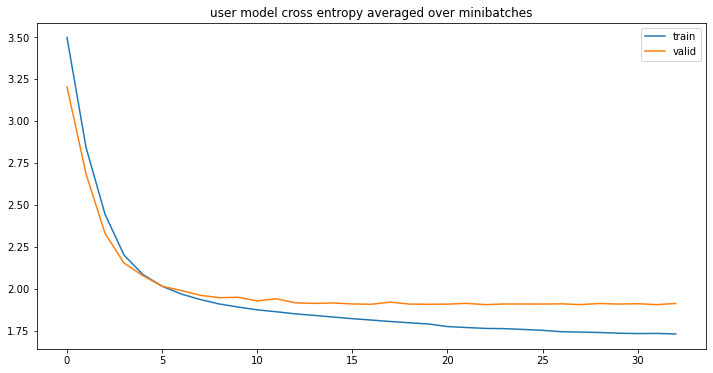

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('user model cross entropy averaged over minibatches')
plt.plot(user_train_epoch_losses, label = "train")
plt.plot(user_valid_epoch_losses, label = "valid")
plt.legend()

In [32]:
user_model.eval()
user_test_X, user_test_Y = map(list, zip(*user_test_data))

user_probs = []
user_test = []

for i in range(len(user_test_Y)):
    g = user_test_X[i].to(device)
    labels = user_test_Y[i]
    labels = labels.tolist()
    user_test += labels
    user_probs_Y = torch.softmax(user_model(g), 1).tolist()
    user_probs += user_probs_Y

In [33]:
print("USER metric")

print("Acc@1:", get_accuracy_k(1, clusters.test_user_df, user_probs, clusters.test_dataset, 0))
print("Acc@3:", get_accuracy_k(3, clusters.test_user_df, user_probs, clusters.test_dataset, 0))
print("Acc@5:", get_accuracy_k(5, clusters.test_user_df, user_probs, clusters.test_dataset, 0))
print("Acc@10:", get_accuracy_k(10, clusters.test_user_df, user_probs, clusters.test_dataset, 0))

USER metric
Acc@1: 0.43422832445332443
Acc@3: 0.7114723776223777
Acc@5: 0.8181893162393162
Acc@10: 0.9238690281940283


## 4.6 Prediction of system clusters

In [36]:
from dgl import nn as dgl_nn
from torch import nn

class GAT_system(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super(GAT_system, self).__init__()

        self.embs = nn.Embedding.from_pretrained(learn_emb).requires_grad_(True)
        self.layer1 = dgl_nn.GATv2Conv(embs_dim, hidden_dim, num_heads)
        self.layer2 = dgl_nn.GATv2Conv(hidden_dim * num_heads, hidden_dim, num_heads)

        self.do1 = nn.Dropout(0.4)
        self.do2 = nn.Dropout(0.4)

        self.linear_weights = nn.Embedding.from_pretrained(linear_weights.float()).requires_grad_(True)  
        
        self.classify = nn.Linear(hidden_dim * num_heads, second_num_clusters)

    def forward(self, bg):
        x = bg.ndata['attr']
        x_emb = bg.ndata['emb']
        embeddings = self.embs.weight
        all_embs = torch.concat((embeddings, centre_mass, intent_embs), dim = 1)
        
        get_embs = lambda i: all_embs[i]
        node_embs = get_embs(x)
        
#         result_embs = torch.concat((node_embs, x_emb), dim = 1)
        result_embs = x_emb
        h = result_embs.to(torch.float32)
        
        h = self.layer1(bg, h)
        h = self.do1(h)
        h = torch.reshape(h, (len(h), num_heads * hidden_dim))      
        h = self.layer2(bg, h)
        h = self.do2(h)

        
        bg.ndata['h'] = h
        h = torch.reshape(h, (len(node_embs) // top_k, top_k, num_heads * hidden_dim))        
        linear_weights_1dim = torch.reshape(self.linear_weights.weight, (top_k, ))
        get_sum = lambda e: torch.matmul(linear_weights_1dim, e)
        h = list(map(get_sum, h))
        hg = torch.stack(h)
        return self.classify(hg)   

In [37]:
system_model = GAT_system(hidden_dim, num_heads).to(device)

for param in system_model.parameters():
    param.requires_grad = True
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(system_model.parameters(), lr = 0.0001)
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping(10)

sys_num_epochs = 100

for epoch in range(sys_num_epochs):
    train_epoch_loss = 0

    for iter, (batched_graph, labels) in tqdm(enumerate(sys_train_data)):
#         print(f"{iter}/{len(sys_train_data)}")
        out = system_model(batched_graph.to(device))
        loss = criterion(out, labels.to(device))
        optimizer.zero_grad()

        loss.backward() 
        optimizer.step() 
        train_epoch_loss += loss.detach().item()
        
    train_epoch_loss /= (iter + 1)
    
    valid_epoch_loss = 0
    with torch.no_grad():
        for iter, (batched_graph, labels) in enumerate(sys_valid_data):
            out = system_model(batched_graph.to(device))
            loss = criterion(out, labels.to(device))
            
            valid_epoch_loss += loss.detach().item()

        valid_epoch_loss /= (iter + 1)

    print(f'Epoch {epoch}, train loss {train_epoch_loss:.4f}, valid loss {valid_epoch_loss:.4f}')  
    wandb.log({'system train loss' : train_epoch_loss, 'system valid loss' : valid_epoch_loss})
    lr_scheduler(valid_epoch_loss)
    early_stopping(valid_epoch_loss)
    
    if early_stopping.early_stop:
        break

222it [00:47,  4.72it/s]


Epoch 0, train loss 3.5192, valid loss 3.2904


222it [00:44,  4.98it/s]


Epoch 1, train loss 2.7656, valid loss 2.6304


222it [00:44,  4.99it/s]


Epoch 2, train loss 2.2025, valid loss 2.1850


222it [00:45,  4.93it/s]


Epoch 3, train loss 1.8834, valid loss 1.9223


222it [00:45,  4.92it/s]


Epoch 4, train loss 1.7068, valid loss 1.7964


222it [00:44,  4.94it/s]


Epoch 5, train loss 1.6121, valid loss 1.7080


222it [00:45,  4.92it/s]


Epoch 6, train loss 1.5539, valid loss 1.6738


222it [00:44,  4.95it/s]


Epoch 7, train loss 1.5148, valid loss 1.6347


222it [00:44,  4.95it/s]


Epoch 8, train loss 1.4845, valid loss 1.6106


222it [00:44,  4.98it/s]


Epoch 9, train loss 1.4602, valid loss 1.5991


222it [00:44,  4.95it/s]


Epoch 10, train loss 1.4394, valid loss 1.6089
Early stopping counter 1 of 10


222it [00:44,  4.96it/s]


Epoch 11, train loss 1.4229, valid loss 1.5917


222it [00:45,  4.86it/s]


Epoch 12, train loss 1.4086, valid loss 1.5748


222it [00:46,  4.73it/s]


Epoch 13, train loss 1.3942, valid loss 1.5755
Early stopping counter 1 of 10


222it [00:45,  4.85it/s]


Epoch 14, train loss 1.3854, valid loss 1.5745


222it [00:45,  4.83it/s]


Epoch 15, train loss 1.3730, valid loss 1.5598


222it [00:45,  4.84it/s]


Epoch 16, train loss 1.3613, valid loss 1.5629
Early stopping counter 1 of 10


222it [00:45,  4.92it/s]


Epoch 17, train loss 1.3526, valid loss 1.5760
Early stopping counter 2 of 10


222it [00:44,  4.94it/s]


Epoch 18, train loss 1.3437, valid loss 1.5674
Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.
Early stopping counter 3 of 10


222it [00:45,  4.86it/s]


Epoch 19, train loss 1.3257, valid loss 1.5550


222it [00:44,  5.03it/s]


Epoch 20, train loss 1.3209, valid loss 1.5612
Early stopping counter 1 of 10


222it [00:44,  5.01it/s]


Epoch 21, train loss 1.3165, valid loss 1.5575
Early stopping counter 2 of 10


222it [00:44,  4.98it/s]


Epoch 22, train loss 1.3102, valid loss 1.5652
Epoch 00023: reducing learning rate of group 0 to 2.5000e-05.
Early stopping counter 3 of 10


222it [00:44,  4.98it/s]


Epoch 23, train loss 1.3016, valid loss 1.5549


222it [00:44,  5.04it/s]


Epoch 24, train loss 1.2992, valid loss 1.5644
Early stopping counter 1 of 10


222it [00:44,  5.01it/s]


Epoch 25, train loss 1.2962, valid loss 1.5564
Epoch 00026: reducing learning rate of group 0 to 1.2500e-05.
Early stopping counter 2 of 10


222it [00:44,  4.97it/s]


Epoch 26, train loss 1.2924, valid loss 1.5604
Early stopping counter 3 of 10


222it [00:56,  3.95it/s]


Epoch 27, train loss 1.2895, valid loss 1.5623
Early stopping counter 4 of 10


222it [00:59,  3.73it/s]


Epoch 28, train loss 1.2900, valid loss 1.5555
Epoch 00029: reducing learning rate of group 0 to 6.2500e-06.
Early stopping counter 5 of 10


222it [00:59,  3.74it/s]


Epoch 29, train loss 1.2859, valid loss 1.5564
Early stopping counter 6 of 10


222it [00:58,  3.78it/s]


Epoch 30, train loss 1.2864, valid loss 1.5594
Early stopping counter 7 of 10


222it [00:58,  3.79it/s]


Epoch 31, train loss 1.2853, valid loss 1.5549
Epoch 00032: reducing learning rate of group 0 to 3.1250e-06.
Early stopping counter 8 of 10


222it [01:00,  3.70it/s]


Epoch 32, train loss 1.2849, valid loss 1.5617
Early stopping counter 9 of 10


222it [00:49,  4.49it/s]


Epoch 33, train loss 1.2847, valid loss 1.5588
Early stopping counter 10 of 10
Early stopping


In [38]:
system_model.eval()
system_test_X, system_test_Y = map(list, zip(*sys_test_data))

system_probs = []
system_test = []

for i in range(len(system_test_Y)):
    g = system_test_X[i].to(device)
    labels = system_test_Y[i]
    labels = labels.tolist()
    system_test += labels
    system_probs_Y = torch.softmax(system_model(g), 1).tolist()
    system_probs += system_probs_Y

In [39]:
print("SYSTEM metric")

print("Acc@1:", get_accuracy_k(1, clusters.test_system_df, system_probs, clusters.test_dataset, 1))
print("Acc@3:", get_accuracy_k(3, clusters.test_system_df, system_probs, clusters.test_dataset, 1))
print("Acc@5:", get_accuracy_k(5, clusters.test_system_df, system_probs, clusters.test_dataset, 1))
print("Acc@10:", get_accuracy_k(10, clusters.test_system_df, system_probs, clusters.test_dataset, 1))

SYSTEM metric
Acc@1: 0.5099656066156066
Acc@3: 0.8220969363969364
Acc@5: 0.9135968697968699
Acc@10: 0.9688914196914198


In [40]:
print("ALL metric")
print("Acc@1:", get_all_accuracy_k(1, clusters.test_user_df, clusters.test_system_df, user_probs, system_probs, clusters.test_dataset))
print("Acc@3:", get_all_accuracy_k(3, clusters.test_user_df, clusters.test_system_df, user_probs, system_probs, clusters.test_dataset))
print("Acc@5:", get_all_accuracy_k(5, clusters.test_user_df, clusters.test_system_df, user_probs, system_probs, clusters.test_dataset))
print("Acc@10:", get_all_accuracy_k(10, clusters.test_user_df, clusters.test_system_df, user_probs, system_probs, clusters.test_dataset))


ALL metric
Acc@1: 0.47209696553446556
Acc@3: 0.7667846570096569
Acc@5: 0.865893093018093
Acc@10: 0.9463802239427239
